In [105]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    Input
)
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [96]:
seed = 1000
batch_size = 64

In [97]:
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=18,
    titlepad=10,
)
plt.rc("image", cmap="magma")

# Dataset

A princípio, os dados serão separados apenas em treinamento e teste


In [98]:
train_base, test_base = image_dataset_from_directory(
    directory="./dataset",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True,
    verbose=True,
)

Found 923 files belonging to 2 classes.
Using 739 files for training.
Using 184 files for validation.


Normalização dos pixels


In [99]:
X_train = train_base.map(lambda x, y: (x / 255.0, y))
X_test = test_base.map(lambda x, y: (x / 255.0, y))

Improving performance by saving data in the cache


In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_base = train_base.cache().prefetch(buffer_size=AUTOTUNE)
# test_base = test_base.cache().prefetch(buffer_size=AUTOTUNE)

# Performance is the same?????

# Modelo


In [1]:
model = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=1024, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.2),
    Dense(units=512, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.2),
    Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    Dense(units=1, activation="sigmoid")
])

model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[BinaryAccuracy()]
)

model.summary()

NameError: name 'Sequential' is not defined

CallBacks


In [102]:
es = EarlyStopping(
    monitor="val_binary_accuracy", patience=20, restore_best_weights=True, verbose=1
)

rlr = ReduceLROnPlateau(monitor="val_binary_accuracy", factor=0.2, patience=10, verbose=True)

In [103]:
history = model.fit(
    X_train,
    validation_data=X_test,
    epochs=200,
    callbacks=[es, rlr],
)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - binary_accuracy: 0.5118 - loss: 18.1190 - val_binary_accuracy: 0.5652 - val_loss: 1.5331 - learning_rate: 0.0010
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - binary_accuracy: 0.7103 - loss: 1.1179 - val_binary_accuracy: 0.6630 - val_loss: 0.6548 - learning_rate: 0.0010
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - binary_accuracy: 0.7176 - loss: 1.1533 - val_binary_accuracy: 0.5870 - val_loss: 0.8043 - learning_rate: 0.0010
Epoch 4/200
 2/12 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - binary_accuracy: 0.8320 - loss: 0.7514

KeyboardInterrupt: 

# Resultados


In [106]:
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_bool = (y_pred > 0.5).astype(int)

y_test = np.concatenate([y for x, y in test_base], axis=0)

print(classification_report(y_test, y_pred_bool))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65        91
         1.0       0.65      0.53      0.58        93

    accuracy                           0.62       184
   macro avg       0.62      0.62      0.62       184
weighted avg       0.63      0.62      0.62       184



<Axes: >

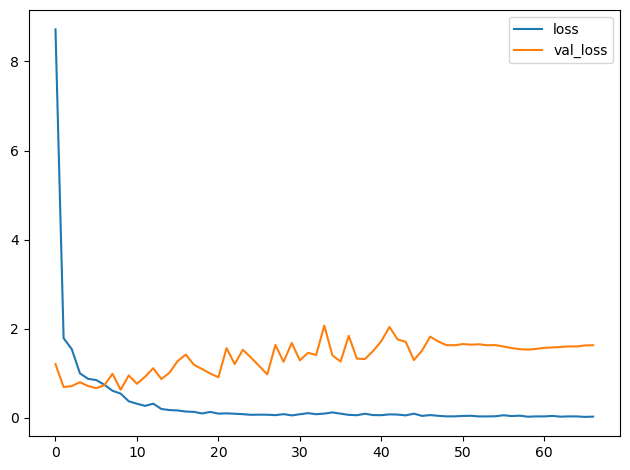

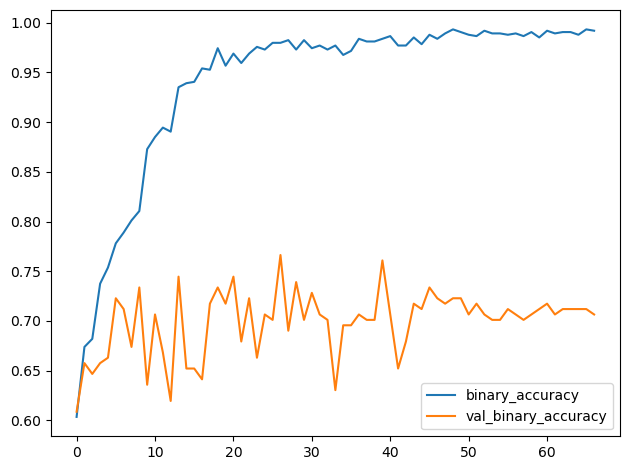

In [93]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ["loss", "val_loss"]].plot()
history_frame.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot()